<a href="https://colab.research.google.com/github/dallinmoore/avalanche-forecasting/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Avalanche Danger

Project by Dallin Moore

---
## Details
Class: DATA 5610 - Deep Learning

Assignment: Final Project

Prof.: Dr. Sharad Jones

In [48]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import date
from pathlib import Path
from typing import Dict, List

import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.strtree import STRtree
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

# CONSTANTS
BASE_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/"


## SNOTEL Data Collection

### Collect Data on Stations

In [49]:
def fetch_snotel_metadata():
    metadata_url = BASE_URL + "stations"
    params = {
        "stationTriplets": "*:UT:SNTL",
        "returnForecastPointMetadata": "false",
        "returnReservoirMetadata": "false",
        "returnStationElements": "false",
        "activeOnly": "true",
        "durations": "HOURLY",
    }
    response = requests.get(metadata_url, params=params, timeout=30)
    if response.ok:
        return response.json()
    print("Request failed with status code:", response.status_code)
    return []

keys = [
    "stationId",
    "stateCode",
    "networkCode",
    "name",
    "countyName",
    "elevation",
    "latitude",
    "longitude",
]

data = fetch_snotel_metadata()
snotel_df = pd.DataFrame([{key: station.get(key, "") for key in keys} for station in data])
snotel_df.head()

,stationId,stateCode,networkCode,name,countyName,elevation,latitude,longitude
0,907,UT,SNTL,Agua Canyon,Kane,8890.0,37.52217,-112.27118
1,1308,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775
2,992,UT,SNTL,Bear River RS,Summit,8510.0,40.88520,-110.82770
3,329,UT,SNTL,Beaver Dams,Sanpete,7970.0,39.13683,-111.55813
4,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782


### Categorize Stations by Region

In [50]:
region_boundaries = {
    "Logan": [[41.2, -111.9], [42.0, -111.9], [42.0, -111.1], [41.2, -111.1]],
    "Ogden": [[40.8, -112.0], [41.2, -112.0], [41.2, -111.1], [40.8, -111.1]],
    "Salt Lake": [[40.4, -112.0], [40.8, -112.0], [40.8, -111.1], [40.4, -111.1]],
    "Uintas": [[40.3, -111.1], [41.0, -111.1], [41.0, -109.4], [40.3, -109.4]],
    "Provo": [[39.8, -112.0], [40.4, -112.0], [40.4, -111.1], [39.8, -111.1]],
    "Skyline": [[38.9, -111.8], [39.8, -111.8], [39.8, -111.1], [38.9, -111.1]],
    "Moab": [[38.0, -109.8], [39.0, -109.8], [39.0, -108.9], [38.0, -108.9]],
    "Abajos": [[37.5, -109.9], [37.9, -109.9], [37.9, -109.1], [37.5, -109.1]],
    "Southwest": [[37.0, -114.0], [38.5, -114.0], [38.5, -112.5], [37.0, -112.5]],
}

SNOTEL stations that are not in the boundaries, but are within 0.3 degrees (roughly 20 miles) are grouped into that region. So some stations are used by multiple regions and some are not included.

In [51]:
region_shapes = {r: Polygon(c) for r, c in region_boundaries.items()}
_poly_list = list(region_shapes.values())
_region_tree = STRtree(_poly_list)

# Two parallel maps so we handle both pygeos‑style (int indices) *and* Shapely 2.x (clone geoms)
_poly_idx_to_region = {idx: region for idx, region in enumerate(region_shapes)}
_poly_wkb_to_region = {poly.wkb: region for region, poly in region_shapes.items()}

def determine_region(lat, lon, min_distance_threshold=0.3):
    """Return **all** regions whose polygon either contains the point or lies
    within *min_distance_threshold* degrees of it.

    Uses a buffered point when querying the STRtree, so regions whose bounding
    box is within the threshold are considered even if the point itself is
    just outside the box.  Works with both Shapely‑2 (geometries returned) and
    older PyGEOS/Shapely‑1 (integer indices returned).
    """
    pt   = Point(lat, lon)               # (lat, lon) order preserved
    buf  = pt.buffer(min_distance_threshold)  # degrees

    regions = []
    for item in _region_tree.query(buf):  # buffered query widens candidate set
        # Shapely‑1 / PyGEOS ⇒ index; Shapely‑2 ⇒ geometry clone
        if isinstance(item, (int, np.integer)):
            poly   = _poly_list[item]
            region = _poly_idx_to_region[item]
        else:
            poly   = item
            region = _poly_wkb_to_region[poly.wkb]

        if poly.contains(pt) or poly.exterior.distance(pt) <= min_distance_threshold:
            regions.append(region)

    return regions


def map_stations_to_regions(df):
    region_stations = {r: [] for r in region_boundaries}
    for _, row in df.iterrows():
        regs = determine_region(row["latitude"], row["longitude"])
        if not regs:
            continue
        st = {
            "stationId": row["stationId"],
            "name": row["name"],
            "elevation": row["elevation"],
            "latitude": row["latitude"],
            "longitude": row["longitude"],
        }
        for r in regs:
            region_stations[r].append(st)

    print("SNOTEL Stations mapped to regions:")
    for region, stations in region_stations.items():
        print(f"{region}: {len(stations)} stations")

    return region_stations

region_stations = map_stations_to_regions(snotel_df)

region_stations['Logan'][:5]

SNOTEL Stations mapped to regions:
Logan: 20 stations
Ogden: 34 stations
Salt Lake: 32 stations
Uintas: 33 stations
Provo: 25 stations
Skyline: 24 stations
Moab: 6 stations
Abajos: 3 stations
Southwest: 19 stations


[{'stationId': '332',
  'name': 'Ben Lomond Peak',
  'elevation': 7700.0,
  'latitude': 41.37603,
  'longitude': -111.94405},
 {'stationId': '333',
  'name': 'Ben Lomond Trail',
  'elevation': 5980.0,
  'latitude': 41.38291,
  'longitude': -111.92103},
 {'stationId': '374',
  'name': 'Bug Lake',
  'elevation': 7980.0,
  'latitude': 41.68541,
  'longitude': -111.41987},
 {'stationId': '455',
  'name': 'Dry Bread Pond',
  'elevation': 8290.0,
  'latitude': 41.41289,
  'longitude': -111.5377},
 {'stationId': '474',
  'name': 'Farmington',
  'elevation': 7920.0,
  'latitude': 40.97462,
  'longitude': -111.80975}]

### Map Each Station to an Elevation Band

Elevation bands are from [Utah Avalanche Center](https://utahavalanchecenter.org/) that are used for their forecasts.

In [52]:
region_elevations = [
  {
    "region": "Logan",
    "elevation_levels": {
      "level_1": {"max": 7000, "min": 0},
      "level_2": {"max": 8500, "min": 7001},
      "level_3": {"max": 20000, "min": 8501}
    }
  },
  {
    "region": "Ogden",
    "elevation_levels": {
      "level_1": {"max": 7000, "min": 0},
      "level_2": {"max": 8500, "min": 7001},
      "level_3": {"max": 20000, "min": 8501}
    }
  },
  {
    "region": "Uintas",
    "elevation_levels": {
      "level_1": {"max": 9500, "min": 0},
      "level_2": {"max": 10000, "min": 9501},
      "level_3": {"max": 20000, "min": 10001}
    }
  },
  {
    "region": "Salt Lake",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501}
    }
  },
  {
    "region": "Provo",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501}
    }
  },
  {
    "region": "Skyline",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501
      }
    }
  }
]

In [53]:
elevation_lookup = {item["region"]: item["elevation_levels"] for item in region_elevations}

def get_elevation_level(elevation, region):
    levels = elevation_lookup.get(region)
    if not levels:
        return 0

    if elevation <= levels["level_1"]["max"]:
        return 1
    if elevation <= levels["level_2"]["max"]:
        return 2
    return 3


for region, stations in region_stations.items():
    for st in stations:
        st["elevation_level"] = get_elevation_level(st["elevation"], region)

print("Sample:")
for region in region_stations:
    print(f"\nRegion: {region}")
    for i, station in enumerate(region_stations[region]):
        if i < 3:  # Just show first 3 stations as examples
            print(f"  Station: {station.get('name', 'Unknown')}, Elevation: {station['elevation']}, Level: {station['elevation_level']}")
    print(f"  ... {len(region_stations[region])} stations total")


Sample:

Region: Logan
  Station: Ben Lomond Peak, Elevation: 7700.0, Level: 2
  Station: Ben Lomond Trail, Elevation: 5980.0, Level: 1
  Station: Bug Lake, Elevation: 7980.0, Level: 2
  ... 20 stations total

Region: Ogden
  Station: Atwater, Elevation: 8750.0, Level: 2
  Station: Bear River RS, Elevation: 8510.0, Level: 1
  Station: Beaver Divide, Elevation: 8230.0, Level: 2
  ... 34 stations total

Region: Salt Lake
  Station: Atwater, Elevation: 8750.0, Level: 2
  Station: Bear River RS, Elevation: 8510.0, Level: 1
  Station: Beaver Divide, Elevation: 8230.0, Level: 2
  ... 32 stations total

Region: Uintas
  Station: Bear River RS, Elevation: 8510.0, Level: 1
  Station: Beaver Divide, Elevation: 8230.0, Level: 2
  Station: Blacks Fork Jct, Elevation: 8880.0, Level: 1
  ... 33 stations total

Region: Provo
  Station: Atwater, Elevation: 8750.0, Level: 2
  Station: Beaver Divide, Elevation: 8230.0, Level: 2
  Station: Bevans Cabin, Elevation: 6470.0, Level: 1
  ... 25 stations total

### Visualize the Stations/Regions

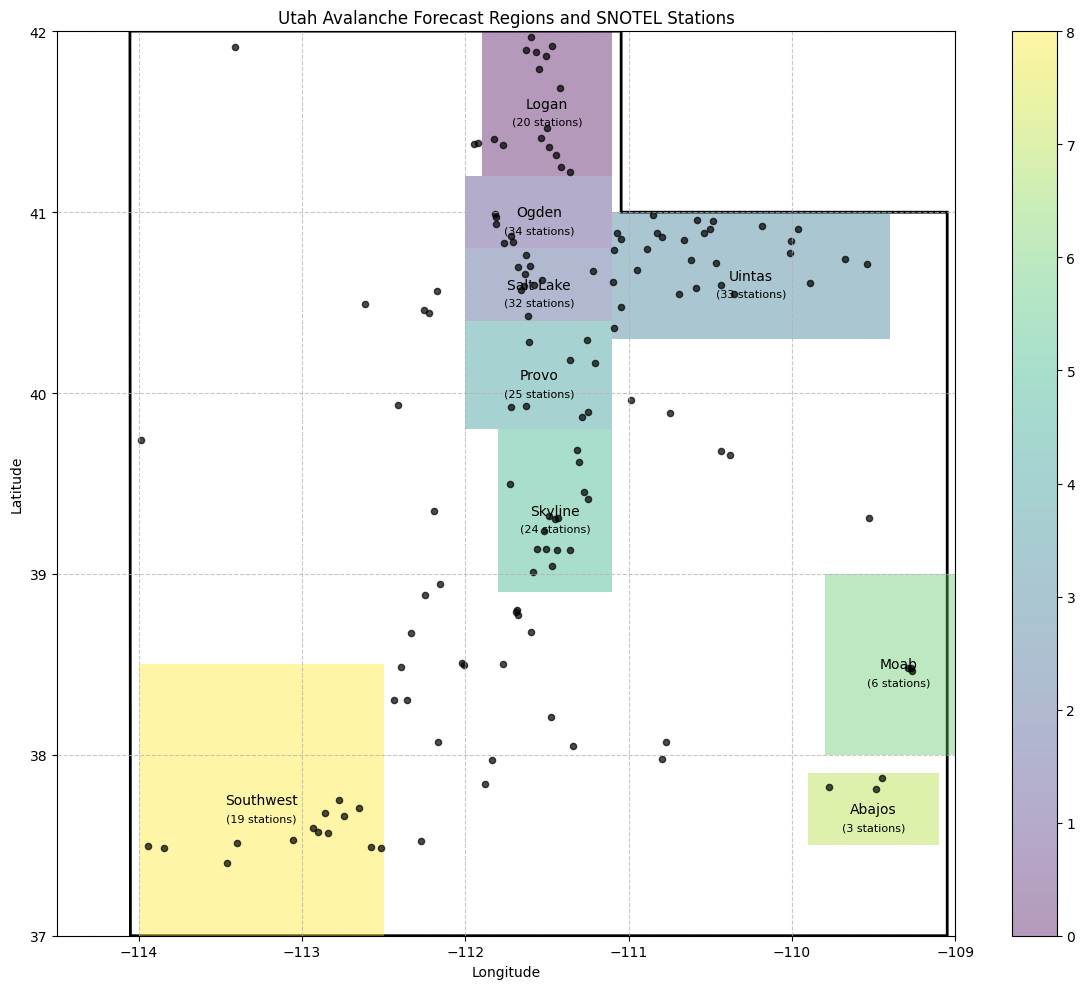

In [54]:
def visualize_regions(snotel_df, region_stations, region_boundaries):
    colors = list(mcolors.TABLEAU_COLORS)

    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)

    utah_boundary = [
        [42.001, -114.053],
        [42.001, -111.046],
        [41.000, -111.046],
        [41.000, -109.050],
        [37.000, -109.050],
        [37.000, -114.050],
        [42.001, -114.053],
    ]

    utah_coords = np.array(utah_boundary)[:, [1, 0]]
    utah_polygon = MplPolygon(utah_coords, closed=True, fill=False, edgecolor="black", linewidth=2)
    ax.add_patch(utah_polygon)

    patches, region_centroids = [], {}
    for coords in region_boundaries.values():
        patches.append(MplPolygon(np.array(coords)[:, [1, 0]], closed=True, fill=True))

    p = PatchCollection(patches, alpha=0.4)
    p.set_array(np.arange(len(patches)))
    ax.add_collection(p)
    plt.colorbar(p)

    for region_name, coords in region_boundaries.items():
        centroid_x = np.mean([p[1] for p in coords])
        centroid_y = np.mean([p[0] for p in coords])
        region_centroids[region_name] = (centroid_x, centroid_y)
        ax.text(centroid_x, centroid_y, region_name, fontsize=10, ha="center", va="center")

    ax.scatter(snotel_df["longitude"], snotel_df["latitude"], c="black", s=20, alpha=0.7, label="SNOTEL Stations")

    for region_name, (x, y) in region_centroids.items():
        ax.text(x, y - 0.1, f"({len(region_stations[region_name])} stations)", fontsize=8, ha="center", va="center")

    ax.set_xlim(-114.5, -109.0)
    ax.set_ylim(37.0, 42.0)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Utah Avalanche Forecast Regions and SNOTEL Stations")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


visualize_regions(snotel_df, region_stations, region_boundaries)

The boundaries are meant to closely match the map used by the [Utah Avalanche Center](https://utahavalanchecenter.org/). Because there are so few stations in the Abajos and Moab region, and their weather patterns differ significantly from the northern 6 regions, they will be ommited. The Southwest region is being ommited as there are no longer avalanche predictions for it.

In [55]:
regions = ["Logan", "Ogden", "Uintas", "Salt Lake", "Provo", "Skyline"]

In [56]:
def get_unique_station_ids(region_stations, regions):
    return list({st["stationId"] for reg in regions for st in region_stations[reg]})

unique_ids = get_unique_station_ids(region_stations, regions)
len(unique_ids)

93

### Fetch the Timeseries SNOTEL Data

In [57]:
# Dictionary of SNOTEL elements
snotel_elements = {
    "Snow_Depth": "SNWD",
    "SWE": "WTEQ",
    "Precipitation_Increment": "PRCP",
    "Snow_Density": "SNDN",
    "Avg_Temp": "TAVG",
    "Max_Temp": "TMAX",
    "Min_Temp": "TMIN",
}

In [58]:
def fetch_snotel_data(triplet, begin_date, end_date, elements):
    data_url = BASE_URL + "data"
    params = {
        "stationTriplets": triplet,
        "beginDate": begin_date,
        "endDate": end_date,
        "elements": ",".join(elements.values()),
        "duration": "DAILY",
    }
    for _ in range(2):
        try:
            resp = requests.get(data_url, params=params, timeout=60)
            if resp.ok:
                return resp.json()
        except Exception as e:
            print(f"Retrying {triplet} after error: {e}")
    print("Failed:", triplet)
    return []


def process_station_data(station_id, start_date, end_date, elements):
    triplet = f"{station_id}:UT:SNTL"
    series = []
    for site in fetch_snotel_data(triplet, start_date, end_date, elements):
        for element in site.get("data", []):
            code = element["stationElement"]["elementCode"]
            col = next(k for k, v in elements.items() if v == code)
            for val in element.get("values", []):
                rec = next((r for r in series if r["Date"] == val["date"]), None)
                if rec is None:
                    rec = {"Date": val["date"], "stationId": station_id}
                    series.append(rec)
                rec[col] = val.get("value")
    return series


def fetch_all_snotel_data( ids, elements, start_date, end_date=date.today().strftime("%Y-%m-%d"), max_workers=15,):
    total = len(ids)
    print(f"Fetching daily SNOTEL data for {total} stations…")

    all_rows = []
    done = 0

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {
            ex.submit(process_station_data, sid, start_date, end_date, elements): sid
            for sid in ids
        }

        for fut in as_completed(futures):
            sid = futures[fut]
            try:
                all_rows.extend(fut.result())
            except Exception as e:
                # keep going, but show which station failed
                print(f"  ✖ {sid} → {e}")
            done += 1

            # Print progress every 10 stations or on the last one
            if done % 10 == 0 or done == total:
                print(f"  {done}/{total} stations complete ({done / total:.0%})")

    return pd.DataFrame(all_rows)



snotel_df_ts = fetch_all_snotel_data(unique_ids, snotel_elements, "2013-12-13")
snotel_df_ts.head()

Fetching daily SNOTEL data for 93 stations…
  10/93 stations complete (11%)
  20/93 stations complete (22%)
  30/93 stations complete (32%)
  40/93 stations complete (43%)
  50/93 stations complete (54%)
  60/93 stations complete (65%)
  70/93 stations complete (75%)
  80/93 stations complete (86%)
  90/93 stations complete (97%)
  93/93 stations complete (100%)


,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density
0,2024-06-22,1321,0.0,0.0,63.3,80.4,48.9,0.0,NaN
1,2024-06-23,1321,0.0,0.0,67.3,84.7,51.4,0.0,NaN
2,2024-06-24,1321,0.0,0.0,65.8,81.3,53.6,0.0,NaN
3,2024-06-25,1321,0.0,0.0,66.6,83.7,55.2,0.0,NaN
4,2024-06-26,1321,0.0,0.0,63.9,79.7,54.5,0.0,NaN


In [59]:
snotel_df_ts.describe()

,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density
count,370499.000000,370583.000000,369121.000000,369144.000000,369058.000000,370589.000000,183912.000000
mean,0.085794,17.043575,39.313300,50.952569,28.879854,5.248564,29.350026
std,0.215018,22.832153,16.206992,17.608990,15.765212,8.025929,9.007813
min,0.000000,0.000000,-147.800000,-147.800000,-147.800000,0.000000,6.200000
25%,0.000000,0.000000,27.000000,37.000000,17.800000,0.000000,22.800000
50%,0.000000,4.000000,38.100000,49.600000,29.100000,0.900000,27.700000
75%,0.100000,30.000000,53.200000,66.000000,41.200000,8.300000,35.000000
max,5.700000,229.000000,83.700000,132.100000,83.700000,82.800000,73.300000


In [60]:
len(snotel_df_ts)

370590

### Combine the Datasets

In [61]:
snotel_dataset = pd.merge(snotel_df_ts, snotel_df, on="stationId", how="left")
snotel_dataset.head()

,Date,stationId,Precipitation_Increment,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,Snow_Density,stateCode,networkCode,name,countyName,elevation,latitude,longitude
0,2024-06-22,1321,0.0,0.0,63.3,80.4,48.9,0.0,NaN,UT,SNTL,Mill Creek Canyon,Salt Lake,6960.0,40.69656,-111.67712
1,2024-06-23,1321,0.0,0.0,67.3,84.7,51.4,0.0,NaN,UT,SNTL,Mill Creek Canyon,Salt Lake,6960.0,40.69656,-111.67712
2,2024-06-24,1321,0.0,0.0,65.8,81.3,53.6,0.0,NaN,UT,SNTL,Mill Creek Canyon,Salt Lake,6960.0,40.69656,-111.67712
3,2024-06-25,1321,0.0,0.0,66.6,83.7,55.2,0.0,NaN,UT,SNTL,Mill Creek Canyon,Salt Lake,6960.0,40.69656,-111.67712
4,2024-06-26,1321,0.0,0.0,63.9,79.7,54.5,0.0,NaN,UT,SNTL,Mill Creek Canyon,Salt Lake,6960.0,40.69656,-111.67712


In [62]:
# Build fast lookup (region, stationId) → station dict once
_region_station_lookup = {reg: {st["stationId"]: st for st in sts} for reg, sts in region_stations.items()}

new_rows = []
for _, row in snotel_dataset.iterrows():
    st_id = row["stationId"]
    regs = [
        reg for reg, d in _region_station_lookup.items() if st_id in d
    ] or ["Unknown"]
    for reg in regs:
        rec = row.copy().to_dict()
        rec["Region"] = reg
        if reg != "Unknown":
            rec["elevation_level"] = _region_station_lookup[reg][st_id]["elevation_level"]
        else:
            rec["elevation_level"] = "Unknown"
        new_rows.append(rec)

snotel_dataset = pd.DataFrame(new_rows)[
    [
        "Region",
        "stationId",
        "elevation_level",
        "Date",
        "name",
        "stateCode",
        "networkCode",
        "countyName",
        "elevation",
        "latitude",
        "longitude",
        "Precipitation_Increment",
        "Snow_Density",
        "Snow_Depth",
        "Avg_Temp",
        "Max_Temp",
        "Min_Temp",
        "SWE",
    ]
]

snotel_dataset.head()


,Region,stationId,elevation_level,Date,name,stateCode,networkCode,countyName,elevation,latitude,longitude,Precipitation_Increment,Snow_Density,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE
0,Ogden,1321,1,2024-06-22,Mill Creek Canyon,UT,SNTL,Salt Lake,6960.0,40.69656,-111.67712,0.0,NaN,0.0,63.3,80.4,48.9,0.0
1,Salt Lake,1321,1,2024-06-22,Mill Creek Canyon,UT,SNTL,Salt Lake,6960.0,40.69656,-111.67712,0.0,NaN,0.0,63.3,80.4,48.9,0.0
2,Provo,1321,1,2024-06-22,Mill Creek Canyon,UT,SNTL,Salt Lake,6960.0,40.69656,-111.67712,0.0,NaN,0.0,63.3,80.4,48.9,0.0
3,Ogden,1321,1,2024-06-23,Mill Creek Canyon,UT,SNTL,Salt Lake,6960.0,40.69656,-111.67712,0.0,NaN,0.0,67.3,84.7,51.4,0.0
4,Salt Lake,1321,1,2024-06-23,Mill Creek Canyon,UT,SNTL,Salt Lake,6960.0,40.69656,-111.67712,0.0,NaN,0.0,67.3,84.7,51.4,0.0


In [63]:
snotel_dataset.describe()

,elevation_level,elevation,latitude,longitude,Precipitation_Increment,Snow_Density,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE
count,657012.000000,657012.000000,657012.000000,657012.000000,656796.000000,326045.000000,656999.000000,653956.000000,653997.000000,653889.000000,657008.000000
mean,1.681096,8373.146198,40.569424,-111.322946,0.089234,29.749879,17.688304,39.763946,51.163028,29.659370,5.538813
std,0.659437,996.790743,0.680876,0.500618,0.222982,9.112070,23.793916,16.308777,17.800329,15.708035,8.505804
min,1.000000,5980.000000,38.679900,-112.252330,0.000000,6.200000,0.000000,-147.800000,-147.800000,-147.800000,0.000000
25%,1.000000,7760.000000,40.295300,-111.636830,0.000000,23.100000,0.000000,27.100000,37.000000,18.300000,0.000000
50%,2.000000,8290.000000,40.675050,-111.432970,0.000000,28.200000,4.000000,38.500000,49.600000,29.700000,0.900000
75%,2.000000,9130.000000,40.921670,-111.089930,0.100000,35.600000,31.000000,53.800000,66.600000,42.100000,8.700000
max,3.000000,10920.000000,41.967690,-109.544010,5.700000,73.300000,229.000000,83.700000,132.100000,83.700000,82.800000


In [64]:
snotel_dataset.to_csv("snotel_dataset.csv", index=False)

## Fetch ERA5 via the Copernicus Climate Data Store

In [4]:
!pip install cdsapi xarray netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.9 MB/s eta 0:00:00


In [12]:
import cdsapi

c = cdsapi.Client(url='https://cds.climate.copernicus.eu/api/v2', key=userdata.get('CCDS_KEY'))

# Define a small bounding box for Utah
utah_area = [42.0, -114.0, 37.0, -109.0]  # [north, west, south, east]

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'data_format': 'netcdf_legacy',
        'variable': '2m_temperature',
        'year': [
            '1979', '1980', '1981',
            '1982', '1983', '1984',
            '1985', '1986', '1987',
            '1988', '1989', '1990',
            '1991', '1992', '1993',
            '1994', '1995', '1996',
            '1997', '1998', '1999',
            '2000', '2001', '2002',
            '2003', '2004', '2005',
            '2006', '2007', '2008',
            '2009', '2010', '2011',
            '2012', '2013', '2014',
            '2015', '2016', '2017',
            '2018', '2019', '2020',
        ],
        'month': '09',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            51, 3, 50,
            4,
        ],
    },
    f'NFrance_hourly_Sep.nc')
print("Downloaded test ERA5 wind data to utah_wind_test.nc")

2025-04-26 22:31:29,482 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


Exception: Not Found

In [20]:
!pip install "cdsapi>=0.7.4"



In [21]:
from google.colab import userdata
import cdsapi

dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "temperature_of_snow_layer"
    ],
    "year": ["2024"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "data_format": "grib",
    "download_format": "unarchived",
    "area": [42, -114, 37, -109]
}


client = cdsapi.Client(url='https://cds.climate.copernicus.eu/api/v2', key=userdata.get('CDS_KEY'))
client.retrieve(dataset, request).download()


HTTPError: 404 Client Error: Not Found for url: https://cds.climate.copernicus.eu/api/v2/retrieve/v1/processes/reanalysis-era5-single-levels


In [7]:
from google.colab import userdata
import cdsapi

c = cdsapi.Client(url='https://cds.climate.copernicus.eu/api/v2', key=userdata.get('CCDS_KEY'))

# Define the bounding box for Utah
utah_area = [42.0, -114.0, 37.0, -109.0]  # [north, west, south, east]

# Request ERA5 data
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '10m_u_component_of_wind',
            '10m_v_component_of_wind',
        ],
        'year': [str(year) for year in range(2013, 2026)],
        'month': [f'{month:02d}' for month in range(1, 13)],
        'day': [f'{day:02d}' for day in range(1, 32)],
        'time': ['00:00', '06:00', '12:00', '18:00'],  # 6-hourly data
        'area': utah_area,
    },
    'utah_wind_2013_2025.nc'
)

print("Downloaded ERA5 wind data to utah_wind_2013_2025.nc")

2025-04-26 22:25:48,164 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


Exception: Not Found

In [5]:
import xarray as xr
import numpy as np
import pandas as pd

# Load the ERA5 NetCDF file
ds = xr.open_dataset('utah_wind_2013_2025.nc')

# Compute wind speed and direction
ds['wind_speed'] = np.sqrt(ds['u10']**2 + ds['v10']**2)  # Wind speed (m/s)
ds['wind_direction'] = np.arctan2(ds['v10'], ds['u10']) * (180 / np.pi)  # Wind direction (degrees)
ds['wind_direction'] = ds['wind_direction'].where(ds['wind_direction'] >= 0, ds['wind_direction'] + 360)

# Define UAC region coordinates
regions_coords = {
    'Logan': (41.74, -111.83),
    'Ogden': (41.22, -111.97),
    'Uintas': (40.77, -110.90),
    'Salt Lake': (40.76, -111.89),
    'Provo': (40.23, -111.66),
    'Skyline': (38.50, -112.00)
}

# Interpolate wind data to each region
wind_data = []
for region, (lat, lon) in regions_coords.items():
    # Interpolate to the region's coordinates using bilinear interpolation
    region_data = ds.interp(latitude=lat, longitude=lon, method='linear')

    # Convert to DataFrame
    df = region_data[['wind_speed', 'wind_direction']].to_dataframe().reset_index()
    df['Region'] = region
    df['Date'] = pd.to_datetime(df['time']).dt.date  # Extract date part for daily aggregation

    # Aggregate to daily values (mean wind speed and direction)
    daily = df.groupby(['Region', 'Date']).agg({
        'wind_speed': 'mean',
        'wind_direction': 'mean'  # Note: Averaging directions can be tricky; consider vector averaging if needed
    }).reset_index()

    wind_data.append(daily)

# Combine all regions into a single DataFrame
wind_df = pd.concat(wind_data, ignore_index=True)
wind_df['Date'] = pd.to_datetime(wind_df['Date'])

# Save the processed wind data
wind_df.to_csv('utah_wind_daily_2013_2025.csv', index=False)
print("Saved processed wind data to utah_wind_daily_2013_2025.csv")
print(wind_df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/utah_wind_2013_2025.nc'

## Fetch MesoWest Data

In [5]:
import requests

# Construct the API query
url = "https://api.synopticdata.com/v2/stations/timeseries"
params = {
    'stid': 'UTBC1',
    'start': '202504010000',
    'end': '202504220000',
    'vars': 'wind_speed,relative_humidity',
    'units': 'speed|mph,humidity|percent',
    'token': 'e73ac3351cc648338703f95c1ce20ec0'
}

# Make the request
response = requests.get(url, params=params)
data = response.json()
print(data)

# Process the data into a DataFrame
observations = data['STATION'][0]['OBSERVATIONS']
df = pd.DataFrame({
    'Date': observations['date_time'],
    'Wind_Speed': observations['wind_speed_set_1'],
    'Relative_Humidity': observations['relative_humidity_set_1']
})
print(df.head())

{'status': 403, 'message': 'Unauthorized. Review your account access settings in the customer console.'}


KeyError: 'STATION'

## Build a Transformer

In [66]:
avy_forecast_df = pd.read_csv("avalanche-forecast-rose.csv")
avy_forecast_df.head()

,Date Issued,Forecast Area,Link,North-lower,Northeast-lower,East-lower,Southeast-lower,South-lower,Southwest-lower,West-lower,...,West-middle,Northwest-middle,North-upper,Northeast-upper,East-upper,Southeast-upper,South-upper,Southwest-upper,West-upper,Northwest-upper
0,3/7/2024,Provo,https://utahavalanchecenter.org/forecast/provo...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,3/7/2024,Moab,https://utahavalanchecenter.org/forecast/moab/...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
2,3/7/2024,Ogden,https://utahavalanchecenter.org/forecast/ogden...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,3/7/2024,Logan,https://utahavalanchecenter.org/forecast/logan...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,3/7/2024,Skyline,https://utahavalanchecenter.org/forecast/skyli...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0


In [71]:
avy_forecast_df = avy_forecast_df.rename(columns={"Forecast Area": "Region", "Date Issued": "Date"})
avy_forecast_df.head()

,Date,Region,Link,North-lower,Northeast-lower,East-lower,Southeast-lower,South-lower,Southwest-lower,West-lower,...,West-middle,Northwest-middle,North-upper,Northeast-upper,East-upper,Southeast-upper,South-upper,Southwest-upper,West-upper,Northwest-upper
0,3/7/2024,Provo,https://utahavalanchecenter.org/forecast/provo...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,3/7/2024,Ogden,https://utahavalanchecenter.org/forecast/ogden...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,3/7/2024,Logan,https://utahavalanchecenter.org/forecast/logan...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,3/7/2024,Skyline,https://utahavalanchecenter.org/forecast/skyli...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0
5,3/7/2024,Salt Lake,https://utahavalanchecenter.org/forecast/salt-...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [69]:
# Drop unused regions
avy_forecast_df = avy_forecast_df[~avy_forecast_df["Forecast Area"].isin(["Moab", "Abajos", "Southwest"])]
set(avy_forecast_df['Forecast Area'])

{'Logan', 'Ogden', 'Provo', 'Salt Lake', 'Skyline', 'Uintas'}

In [79]:
# Define weather features to aggregate
snotel_features = ["Precipitation_Increment", "Snow_Density", "Snow_Depth",
                    "Avg_Temp", "Max_Temp", "Min_Temp", "SWE"]

# Aggregate weather data by Region, Date_Issued, and Elevation_Band
snotel_agg = snotel_dataset.groupby(["Region", "Date", "elevation_level"])[snotel_features].mean().reset_index()

len(snotel_agg)

72250

In [76]:
snotel_agg["Date"] = pd.to_datetime(snotel_agg["Date"]).dt.strftime("%Y-%m-%d")
avy_forecast_df["Date"] = pd.to_datetime(avy_forecast_df["Date"]).dt.strftime("%Y-%m-%d")

In [78]:
merged_df = pd.merge(
    snotel_agg,
    avy_forecast_df,
    on=["Region", "Date"],
    how="inner"
)
merged_df

,Region,Date,elevation_level,Precipitation_Increment,Snow_Density,Snow_Depth,Avg_Temp,Max_Temp,Min_Temp,SWE,...,West-middle,Northwest-middle,North-upper,Northeast-upper,East-upper,Southeast-upper,South-upper,Southwest-upper,West-upper,Northwest-upper
0,Logan,2013-12-13,1,0.085714,22.057143,16.142857,19.900000,30.028571,12.642857,3.371429,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0
1,Logan,2013-12-13,2,0.050000,22.850000,17.400000,19.800000,26.420000,12.750000,3.980000,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0
2,Logan,2013-12-13,3,0.100000,22.150000,26.000000,17.450000,22.550000,13.800000,5.750000,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0
3,Logan,2013-12-14,1,0.000000,24.514286,15.142857,21.728571,29.828571,12.800000,3.371429,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0
4,Logan,2013-12-14,2,0.020000,23.550000,17.000000,20.080000,26.280000,13.850000,3.990000,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29055,Uintas,2025-04-13,2,0.000000,37.300000,28.375000,36.637500,47.175000,23.837500,10.775000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
29056,Uintas,2025-04-13,3,0.000000,33.637500,39.375000,33.137500,43.675000,19.500000,13.450000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
29057,Uintas,2025-04-14,1,0.005882,36.723077,14.176471,37.611765,53.994118,20.135294,5.182353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29058,Uintas,2025-04-14,2,0.000000,37.362500,27.000000,36.100000,51.312500,19.412500,10.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
elevation_mapping = {"level_1": "lower", "level_2": "middle", "level_3": "upper"}
merged_df["elevation_level"] = merged_df["elevation_level"].map(elevation_mapping)

In [87]:
aspects = ["North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest"]
elevation_levels = ["lower", "middle", "upper"]

In [88]:
# Create a list to store the reshaped data
combined_data = []

for _, row in merged_df.iterrows():
    region = row["Region"]
    date_issued = row["Date"]
    elevation_level = row["elevation_level"]

    # Only process rows where the elevation band matches the forecast columns
    for aspect in aspects:
        # Construct the forecast column name (e.g., "North-lower")
        forecast_col = f"{aspect}-{elevation_level}"
        if forecast_col in row:
            # Extract weather features
            weather_vals = {feat: row[feat] for feat in snotel_features}
            # Create a new row
            combined_data.append({
                "Region": region,
                "Date": date,
                "elevation_level": elevation_level,
                "Aspect": aspect,
                **weather_vals,
                "Risk_Level": row[forecast_col]
            })

# Convert to DataFrame
combined_df = pd.DataFrame(combined_data)

# Check the result
len(combined_df)#.head()

0